In [1]:
""" Some data examination """
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from IPython import display
from time import sleep
from cv2 import resize as resize

def plot_rollout():
    """ Plot a rollout """
    from torch.utils.data import DataLoader
    from data.loaders import RolloutSequenceDatasetVis
    
    dataloader = DataLoader(
        RolloutSequenceDatasetVis(
            root='datasets_ppo_rollouts_vae_mdrnn//carracing', seq_len=900,
            transform=lambda x: x, buffer_size=10,
            train=False),
        batch_size=1, shuffle=True)

    
    dataloader.dataset.load_next_buffer()
    
    
    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
    
    #ax = fig.gca()
    #fig.show()
    for data in dataloader:
        
        obs_seq = data[0].numpy().squeeze()
        for obs in obs_seq:
            obs1 = obs[:,:,0]
            obs2 = obs[:,:,1]
            obs3 = obs[:,:,2]
            #ax1.imshow(obs1, cmap='gray')
            #ax2.imshow(obs2, cmap='gray')
            #ax3.imshow(obs3, cmap='gray')
            #fig.canvas.draw()
            #sleep(0.1)
            
        break
    return obs_seq


obss = plot_rollout()
print(obss.shape)
#obss = np.array([ resize(obs, (64,64)) for obs in obss])
#print(obss.shape)

Loading file buffer ...: 100%|██████████| 10/10 
Loading file buffer ...: 100%|██████████| 10/10 

(8, 96, 96, 3)


In [14]:
from os.path import join, exists
from models.vae import VAE
import torch
from data.loaders import RolloutObservationDataset
from torchvision import transforms

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

cuda = torch.cuda.is_available()

torch.manual_seed(123)
# Fix numeric divergence due to bug in Cudnn
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if cuda else "cpu")

dataset_train = RolloutObservationDataset('datasets_ppo_rollouts_vae_mdrnn/carracing',
                                          transform_test, train=True)

train_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=100, shuffle=True, num_workers=2)

dataset_train.load_next_buffer()

vae_file = join('./training', 'vae', 'best.tar')
assert exists(vae_file), "No trained VAE in the logdir..."
state = torch.load(vae_file)
print("Loading VAE at epoch {} "
      "with test error {}".format(
          state['epoch'], state['precision']))

vae = VAE(3, 32).to(device)
vae.load_state_dict(state['state_dict'])
vae.eval()
for batch_idx, data in enumerate(train_loader):
    data = data.to(device)
    recon_batch, mu, logvar = vae(data)
    break
    

#decoded = decoded.cpu()
#print(decoded.shape)

Loading file buffer ...: 100%|██████████| 200/200 
Loading file buffer ...: 100%|██████████| 200/200 


Loading VAE at epoch 206 with test error 45.223896564392874


(100, 3, 64, 64)


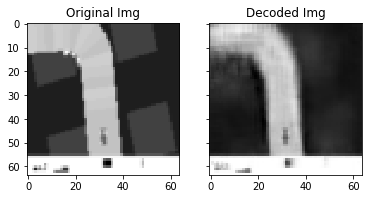

In [17]:

#decoded = recon_batch.detach().cpu().numpy()
#data = data.detach().cpu().numpy()
import matplotlib.pyplot as plt
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
print(data.shape)
ax1.imshow(data[60].transpose(1,2,0)[:,:,0], cmap='gray')
ax1.set_title('Original Img')
ax2.imshow(decoded[60].transpose(1,2,0)[:,:,0], cmap='gray')
ax2.set_title('Decoded Img')
plt.show()
#plt.figure()
#plt.imshow(decoded[30].transpose(1,2,0))


In [ ]:
from os.path import join, exists
import numpy as np
from models.vae import VAE
from models.mdrnn import MDRNNCell
import torch
from data.loaders import RolloutSequenceDataset
from torchvision import transforms
from utils.misc import ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE
from torch.utils.data import DataLoader
import torch.nn.functional as f
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
from time import sleep
import matplotlib
matplotlib.use('TkAgg')

def to_latent(obs, next_obs):
    """ Transform observations to latent space.

    :args obs: 5D torch tensor (BSIZE, SEQ_LEN, ASIZE, SIZE, SIZE)
    :args next_obs: 5D torch tensor (BSIZE, SEQ_LEN, ASIZE, SIZE, SIZE)

    :returns: (latent_obs, latent_next_obs)
        - latent_obs: 4D torch tensor (BSIZE, SEQ_LEN, LSIZE)
        - next_latent_obs: 4D torch tensor (BSIZE, SEQ_LEN, LSIZE)
    """
    
    
    with torch.no_grad():
        obs, next_obs = [
            f.upsample(x.view(-1, 3, SIZE, SIZE), size=RED_SIZE,
                       mode='bilinear', align_corners=True)
            for x in (obs, next_obs)]

        (obs_mu, obs_logsigma), (next_obs_mu, next_obs_logsigma) = [
            vae(x)[1:] for x in (obs, next_obs)]
        
        
        
        latent_obs, latent_next_obs = [
            (x_mu + x_logsigma.exp() * torch.randn_like(x_mu)).view(16, 32, LSIZE)
            for x_mu, x_logsigma in
            [(obs_mu, obs_logsigma), (next_obs_mu, next_obs_logsigma)]]
    return latent_obs, latent_next_obs

transform = transforms.Lambda(
    lambda x: np.transpose(x, (0, 3, 1, 2)) / 255)


cuda = torch.cuda.is_available()

torch.manual_seed(123)
# Fix numeric divergence due to bug in Cudnn
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if cuda else "cpu")

loader = DataLoader(
    RolloutSequenceDataset('datasets/carracing', 32, transform, train=False, buffer_size=10),
    batch_size=16, num_workers=8,drop_last=True)

loader.dataset.load_next_buffer()

vae_file, rnn_file, ctrl_file = \
            [join("./training", m, 'best.tar') for m in ['vae', 'mdrnn', 'ctrl']]

assert exists(vae_file) and exists(rnn_file),\
    "Either vae or mdrnn is untrained."

vae_state, rnn_state = [
    torch.load(fname, map_location={'cuda:0': str(device)})
    for fname in (vae_file, rnn_file)]


vae = VAE(3, 32).to(device)
vae.load_state_dict(vae_state['state_dict'])

mdrnn = MDRNNCell(LSIZE, ASIZE, RSIZE, 5).to(device)
mdrnn.load_state_dict(
            {k.strip('_l0'): v for k, v in rnn_state['state_dict'].items()})

vae.eval()
mdrnn.eval()
 
hidden = [torch.zeros(1, RSIZE).to(device)
            for _ in range(2)]
fig, (ax1, _) = plt.subplots(1, 2, figsize=(15,15))

ax = fig.gca()
fig.show()

for i, data in enumerate(loader):
    obss, actions, reward, terminal, next_obs = [arr.to(device) for arr in data]
    latent_obss, latent_next_obs = to_latent(obss, next_obs)
    for j in range(latent_obss.shape[1]):
        
        action = actions[0][j].unsqueeze(0)
        latent_obs = latent_obss[0][j].unsqueeze(0)
        with torch.no_grad():
            #latent_obs, action, reward, terminal, latent_next_obs = [arr.transpose(1, 0)
            #                   for arr in [latent_obs, action,
            #                               reward, terminal,
            #                               latent_next_obs]]
            #mus, sigmas, logpi, rs, ds = mdrnn(action, latent_obs)
            #print(mus.shape)
            #eps = torch.randn_like(sigmas[0])
            #z = eps.mul(sigmas[0]).add_(mus[0])

            #recon_x = vae.decoder(latent_obs[:,0,:])
            #print(recon_x.shape)
            
            mu, sigma, pi, r, d, hidden = mdrnn(action, latent_obs, hidden)
            pi = pi.squeeze()
            mixt = Categorical(torch.exp(pi)).sample().item()
            

            lstate = mu[:, mixt, :] 
            obs = vae.decoder(lstate)
            np_obs = obs.cpu().numpy()
            np_obs = np.clip(np_obs, 0, 1) * 255
            np_obs = np.transpose(np_obs, (0, 2, 3, 1))
            np_obs = np_obs.squeeze()
            np_obs = np_obs.astype(np.uint8)
            visual_obs = np_obs
            #figure = plt.figure()
            #plt.imshow(visual_obs, cmap='gray')
            ax1.imshow(visual_obs, cmap='gray')
            fig.canvas.draw()
            sleep(0.1)
        
    
    